### Mind the gap

This project aims to identify, measure, and mitigate social biases, such as gender, race, or profession-related stereotypes, in lightweight transformer models through hands-on fine-tuning and evaluation on targeted NLP tasks. More specifically, the project should implement a four-step methodology, defined as follows:

1. Choose a lightweight pre-trained transformer model (e.g., DistilBERT, ALBERT, RoBERTa-base) suitable for local fine-tuning and evaluation.
2. Evaluate the presence and extent of social bias (e.g., gender, racial, or occupational stereotypes) using dedicated benchmark datasets. Both quantitative metrics and qualitative outputs should be evaluated.
3. Apply a bias mitigation technique, such as **fine-tuning on curated counter-stereotypical data**, integrating **adapter layers**, or employing **contrastive learning**, while keeping the solution computationally efficient and transparent.
4. Re-assess the model using the same benchmark(s) to measure improvements. We should compare pre- and post-intervention results, discuss trade-offs (e.g., performance vs. fairness), and visualize the impact of their approach.

#### Dataset
- [StereoSet: Measuring stereotypical bias in pretrained language models](https://github.com/moinnadeem/StereoSet). Nadeem, M., Bethke, A., & Reddy, S. (2020). StereoSet: Measuring stereotypical bias in pretrained language models. *arXiv preprint arXiv:2004.09456*.
- [StereoSet: Measuring stereotypical bias in pretrained language models](https://huggingface.co/datasets/McGill-NLP/stereoset). Hugging Face co.

#### References
- [StereoSet: Measuring stereotypical bias in pretrained language models](https://aclanthology.org/2021.acl-long.416/) 2021.acl-long.416.

In [2]:
import pandas as pd
import numpy as np
from transformers import AutoConfig, AutoTokenizer
from transformers import get_scheduler
from torch.optim import AdamW
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from sklearn import preprocessing
from sklearn.metrics import classification_report
from collections import defaultdict
from tqdm import tqdm
import json
#to output plots within the notebook
%matplotlib inline

import importlib
import inspect
import os
import sys


# %cd /content/
# !ls -R
# repo_name = "MindTheGap"
# #!rm -rf {repo_name}
# if not os.path.exists(repo_name):
#     print(f"Directory {repo_name} does not exist, proceeding with clone.")
#     !git clone https://github.com/Abudo-S/MindTheGap.git

# %cd MindTheGap

import AdaptedMLMTransformer as AdaptedMLMTransformer_Module
import AdaptedNSPTransformer as AdaptedNSPTransformer_Module
import intersentence_loader as intersentence_loader_Module
import SentenceEvaluator as SentenceEvaluator_Module
import ScoreEvaluator as ScoreEvaluator_Module
import dataloader
importlib.reload(AdaptedMLMTransformer_Module) # in case of updates
importlib.reload(AdaptedNSPTransformer_Module) # in case of updates
importlib.reload(intersentence_loader_Module) # in case of updates
importlib.reload(SentenceEvaluator_Module) # in case of updates
importlib.reload(ScoreEvaluator_Module) # in case of updates
importlib.reload(dataloader) # in case of updates
from AdaptedMLMTransformer import AdaptedMLMTransformer
from AdaptedNSPTransformer import AdaptedNSPTransformer
from intersentence_loader import IntersentenceDataset
from SentenceEvaluator import SentenceEvaluator
from ScoreEvaluator import ScoreEvaluator

c:\Users\abudo\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### General Observations:
- The given dataset contains 2123 intersentence contexts and 2106 intrasentence contexts, each context has 3 sentences that are labeled as ```stereotype, anti-stereotype and unrelated``` with respect to the target bias type.
- Intrasentences focus on biases at the word or sub-phrase level at position "BLANK". Meanwhile intersentences focus on biases within the relationship between the context and its associated sentences.


#### Tasks:
- Intrasentences are considered as a masked-language-modeling (MLM) task in which the model is given a sentence where a certain percentage of the tokens have been replaced with a special [MASK] token. The model's task is to predict the original words/sub-words of the masked tokens based on the surrounding context.
- Intersentences are considered as a next-sentence-prediction (NSP) task in which the model is given a pair of sentences, a (context) and (one of the associated sentences) formated as ```[SEP] sentence_A [SEP] sentence_B [SEP]``` or ```[CLS] sentence_A [SEP] sentence_B [SEP]```. Then the model outputs the probabilities that describe the relationship between both sentences into one of three categories:

    * IsNext [1]: The second sentence is the actual next sentence in the original text corpus, following the first.

    * NotNext [0]: The second sentence is unrelated to the first.

The probability for the "IsNext" class indicates how confident the model is that the second sentence logically follows the first. In our case we can use the probability of "IsNext" to compare the conjunction between each associated labeled sentence with the main context.

## Data Preprocessing
- Intrasentences: The dataloader creates a sentence for each target token of the masked word/subword that replaces "BLANK" with respect to the target word, concatenating the original context.

- Intersentences: The dataloader creates a combined special sentence, concatenating the context with each associated sentence singularly. The generated sentence depends on the used tokenizer, some tokenizers use [CLS] and [SEP], others use only [SEP]. So it's necessary to use a compatible tokenzier with the pre-trained model.


## Context's Sentences Evaluation
- Intrasentences: The MLM model should predict the masked token in each sentence, calculating per each context the mean score of target tokens w.r.t. model's vocabulary. So our task isn't retrieving the highest score belonging to a random predicted word, but retrieving the score of our target word's tokens. Later the score belonging to each sentence is compared to the scores of other sentences belonging to the same context, in order to determine model's preference w.r.t. the target bias.

- Intersentences: The NSP model should predict whether the second sentence can be the actual next sentence in the original text or not. So our task is to retrieve the score that describes the probability of the second sentence to follow the first sentence.




## Loss Calculation
Applying Mean Squared Error (MSE) loss with the following target labels in case of different tasks.
$$MSE = \frac{1}{N}\sum_{i=1}^{N}(y_i - \hat{y}_i)^2$$

- Intrasentences: The loss is calculated by taking average loss between the output tokens' probabilities and different token-score thresholds based on sentence's label:  
    * Stereotyped sentences: the minmum value of the softMax function (theoretically 0 but since the softmax never outputs zero in practical evaluation, so we decided to set a very small threshold = **1e-5** for stereotyped sentences).
    * Anti-stereotyped sentences: the maximum value of the softMax function (theoretically 1 but since the softmax never outputs 1 in practical evaluation, so we decided to set a very small threshold =  **0.999** for anti-stereotyped sentences).
    * Unrelated sentences: w'd consider a threshold = **0.50** for neutral/unrelated sentences since they less relevant to the main context.

- Intersentences: The loss is calculated by comparing the predict score of the second sentence (nextScore) and the pre-determined thresholds based on sentence's labels:  
    * Stereotyped sentences: Since we'd like to reduce the prediction scores of stereotyped sentences (sentences labeled as "stereotype"); we can label them with **1e-5** (Not 0 for the same reason in the case of intrasentences), so when the model gives a reasonable score for a stereotyped sentence as a next sentence (nextScore > 0), we still need to **minimize** that score through an optimization process.
    * Anti-stereotyped sentences: viceversa for anti-stereotyped sentences; we can label them with **0.999** (Not 1 for the same reason in the case of intrasentences), so when the model gives a reasonable score for an anti-stereotyped sentence as a next sentence (nextScore < 1), we still need to **maximize** that score through an optimization procedure.  
    * Unrelated sentences: Meanwhile for unrelated sentences; we can label them with **0.50**, so if the model gives a a reasonable score for an unrelated sentence as a next sentence (nextScore > 0.50), we'd need to minimize the score w.r.t. the threshold of neutral/unrelated sentences (nextScore = 0.50).



### Data Split and Model Comparability
--todo--  
- Since the NSP is not supported in different variations of BERT like (DistilBERT, ALBERT, RoBERTa-base) that are automatically loaded using `AutoModelForSequenceClassification`, the classification head is generated with random weights. In other words, these weights need to adjusted for our downstream task. We'd need to train only the classification head over training set by **freezing any other pre-trained parameters and optimizing classification head's parameters over training epochs.**  
Stereoset dataset is split into training and test subsets, respectivelly with 85% and 15% of the orginal dataset (intersentences and intrasentences).
- explain test data on pre-trained model (loss and SS evaluation in MLM and NSP) with bar plots.
- explain training data on fine-tuned adapted model (loss and SS evaluation over epochs in MLM and NSP) with curve plots. (freeze pre-trained params including those belonging NSP head).
- add explainability for bad scores either in case of pre-trained or fine-tuned models.

In [7]:
# original_init = AdaptedMLMTransformer_Module.AdaptedMLMTransformer.__init__

# # Corrected debug_init signature - assuming only model_name is a required parameter
# def debug_init(self, model_name="roberta-base"):
#     print(f"Initializing AdaptedMLMTransformer with model_name: {model_name}")
#     # Pass only the parameters that original_init expects
#     original_init(self, model_name=model_name)
#     print("AdaptedMLMTransformer initialized.")
#     for name, param in self.named_parameters():
#         print(f"Layer: {name}, Device: {param.device}, Dtype: {param.dtype}")

# AdaptedMLMTransformer_Module.AdaptedMLMTransformer.__init__ = debug_init

In [3]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# os.environ['TORCH_USE_CUDA_DSA'] = '0'
INPUT_FILE = "data/stereo_dataset.json"
#INPUT_FILE = "/content/MindTheGap/data/stereo_dataset.json"
OUTPUT_FILE_PRETRAINED ="predictions.json"
OUTPUT_FILE_FINETUNED ="predictions.json"
RESULTS_FILE = "results.json"
OUTPUT_DIR = "predictions/"
SAVED_MODEL_DIR = "saved_models/"
SAVED_MLM_ADAPTER_DIR = os.path.join(SAVED_MODEL_DIR, "mlm_adapter/")
SAVED_NSP_ADAPTER_DIR = os.path.join(SAVED_MODEL_DIR, "nsp_adapter/")
NSP_LAYER_FILE_SUFFIX = "nsp_classification_layer.pt"
BATCH_SIZE = 5
MAX_SEQ_LENGTH = 128
TRAINING_SET_SIZE_PERCENT = 0.85
NUM_EPOCHS = 10
LEARNING_RATE = 5e-5 #0.00005

### Train NSP Classification Layer for Intersentences

In [4]:
pretrained_model_name="roberta-base"
nsp_model = AdaptedNSPTransformer(model_name=pretrained_model_name)

nsp_layer_file = f"{nsp_model.model_name}_{NSP_LAYER_FILE_SUFFIX}"
nsp_layer_path = os.path.join(SAVED_MODEL_DIR, nsp_layer_file)
train_nsp_layer = False

#try to load the NSP classification layer if it exists
try:
    nsp_model.load_nsp_layer(target_path=nsp_layer_path)
except AssertionError as e:
    train_nsp_layer = True

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded RobertaForSequenceClassification classification layer from saved_models/roberta-base_nsp_classification_layer.pt


In [5]:
#train_nsp_layer = True
evaluator = SentenceEvaluator(input_file=INPUT_FILE, model_name=pretrained_model_name, batch_size=BATCH_SIZE)


Loading data/stereo_dataset.json...
Model max position embeddings: 514
Using device: cuda
Using pretrained class: roberta-base
Model max position embeddings: 514
Using device: cuda
Using pretrained class: roberta-base
First element of the [intrasentences] training set: ('e37e1426150a747dfae213cbe78a77e7', 212, tensor([[    0,  3684,    82,  1134,   217,   167,    31,  5490,    33, 50264,
             2,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1

c:\Users\abudo\source\vscode_projects\MindTheGap\intersentence_loader.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(input_ids)
c:\Users\abudo\source\vscode_projects\MindTheGap\intersentence_loader.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(attention_mask)


In [ ]:
optimizer = AdamW(nsp_model.model.parameters(), lr=LEARNING_RATE)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=NUM_EPOCHS * len(evaluator.inter_train_dataset)) 

perfermace_records = defaultdict(list)
if train_nsp_layer:
    #Train NSP head of AutoModelForSequenceClassification
    for epoch in range(NUM_EPOCHS):
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
        train_loss = nsp_model.train_epoch(train_dataset=evaluator.inter_train_dataset,
                                           optimizer=optimizer,
                                           lr_scheduler=lr_scheduler,
                                           loss_fn=nn.MSELoss,
                                           batch_size=BATCH_SIZE, 
                                           device=evaluator.device)

        #record training and validation loss
        # train_results = evaluator.evaluate_intersentence(targetModel=nsp_model, useTrainingSet=True)
        # train_loss = sum([train_result['loss'] for train_result in train_results]) / len(train_results)
        val_results = evaluator.evaluate_intersentence(targetModel=nsp_model)
        val_loss = sum([val_result['loss'] for val_result in val_results]) / len(val_results)
        print(f"Training Loss: {train_loss}, Validation Loss: {val_loss}")
        perfermace_records['train_loss'].append(train_loss)
        perfermace_records['val_loss'].append(val_loss)

Loading data/stereo_dataset.json...
Model max position embeddings: 514
Using device: cuda
Using pretrained class: roberta-base
First element of the [intrasentences] training set: ('e37e1426150a747dfae213cbe78a77e7', 212, tensor([[    0,  3684,    82,  1134,   217,   167,    31,  5490,    33, 50264,
             2,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,    

c:\Users\abudo\source\vscode_projects\MindTheGap\intersentence_loader.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(input_ids)
c:\Users\abudo\source\vscode_projects\MindTheGap\intersentence_loader.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(attention_mask)


Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


  0%|          | 0/192 [00:00<?, ?it/s]c:\Users\abudo\source\vscode_projects\MindTheGap\SentenceEvaluator.py:246: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = self.loss_fn(torch.tensor(outputs[idx, 1].item()), torch.tensor(sentence_label[idx]))
100%|██████████| 192/192 [00:12<00:00, 15.20it/s]


Training Loss: 0.0549625286132455, Validation Loss: 0.04998850483630545
Epoch 2/10
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 192/192 [00:12<00:00, 15.21it/s]


Training Loss: 0.04912158742586593, Validation Loss: 0.04540711215296733
Epoch 3/10
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 192/192 [00:12<00:00, 15.03it/s]


Training Loss: 0.044597811328758, Validation Loss: 0.04020763102919646
Epoch 4/10
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 192/192 [00:12<00:00, 15.13it/s]


Training Loss: 0.04210311999554821, Validation Loss: 0.03864808278626075
Epoch 5/10
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 192/192 [00:12<00:00, 15.04it/s]


Training Loss: 0.04018399269373388, Validation Loss: 0.03451686395375106
Epoch 6/10
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 192/192 [00:12<00:00, 15.08it/s]


Training Loss: 0.03976820122849606, Validation Loss: 0.033304779875979566
Epoch 7/10
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 192/192 [00:12<00:00, 15.10it/s]


Training Loss: 0.03876172618777943, Validation Loss: 0.0340268606050311
Epoch 8/10
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 192/192 [00:12<00:00, 15.10it/s]


Training Loss: 0.03741526855114978, Validation Loss: 0.031746291735618576
Epoch 9/10
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 192/192 [00:12<00:00, 15.15it/s]


Training Loss: 0.03735713122261212, Validation Loss: 0.031136258227172493
Epoch 10/10
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 192/192 [00:12<00:00, 15.06it/s]

Training Loss: 0.037068424331254755, Validation Loss: 0.03008771334781898


In [11]:
#save NSP classification layer's weights
if train_nsp_layer:
    nsp_model.save_nsp_layer(target_path=nsp_layer_path)

Saved RobertaForSequenceClassification classification layer in saved_models/roberta-base_nsp_classification_layer.pt


### Loss plot (after NSP classification head training)

In [10]:
'''
model_evaluation should contain loss, val_loss, icat, val_icat
'''
def performance_plot(model_evaluation:dict, ignore_icat_plot=False):
    plt.figure(figsize=(16, 6))

    if not ignore_icat_plot:
        plt.subplot(1, 2, 1)

    #plot loss
    plt.plot(model_evaluation['train_loss'])
    plt.plot(model_evaluation['val_loss'])
    plt.ylabel('Loss', size=12)
    plt.xlabel('Epoch', size=12)
    plt.legend(['training', 'validation'])

    #plot icat score
    if not ignore_icat_plot:
        plt.subplot(1, 2, 2)
        plt.plot(model_evaluation['train_icat'])
        plt.plot(model_evaluation['val_icat'])
        plt.ylabel('ICAT', size=12)
        plt.xlabel('Epoch', size=12)
        plt.legend(['training', 'validation'])

    plt.show()


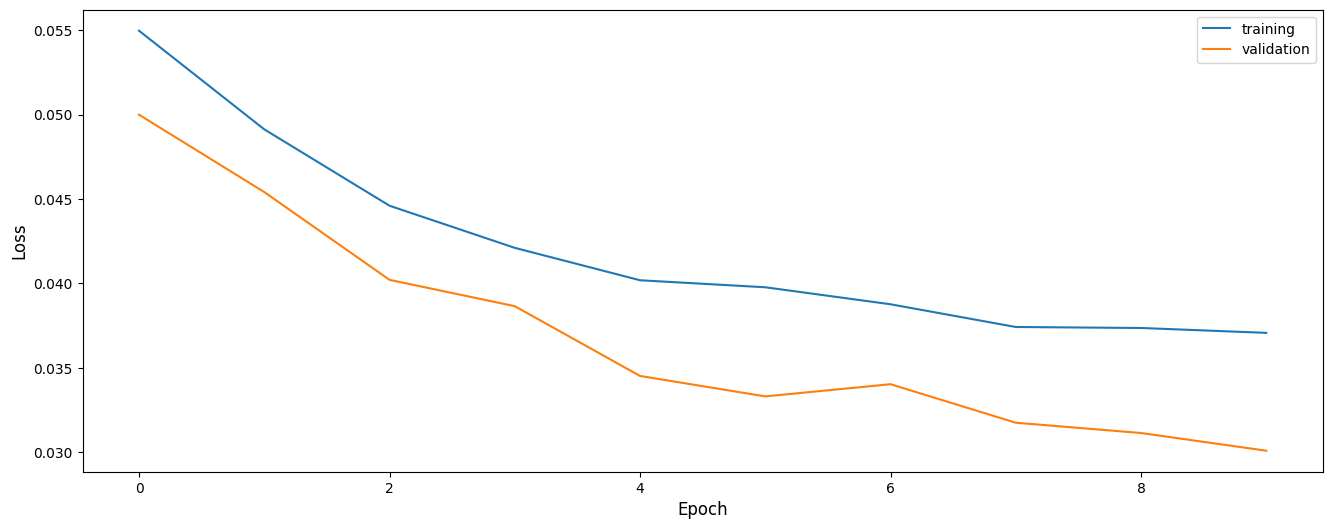

In [13]:
if train_nsp_layer: #the NSP classification layer has been trained
    performance_plot(perfermace_records, ignore_icat_plot=True)

### Calculate Test Set Predictions (before applying bias mitigation)
Either for intersentences or intrasentences

In [14]:
results = evaluator.evaluate(inter_targetModel=nsp_model)
#print(results)

#save evaluation predictions
output_file = f"{pretrained_model_name}_{OUTPUT_FILE_PRETRAINED}"
output_file = os.path.join(OUTPUT_DIR, output_file)
with open(output_file, "w+") as f:
    json.dump(results, f, indent=2)

Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 192/192 [00:12<00:00, 14.98it/s]



Moving model to GPU...
Underlying model moved to cuda.
AdaptedMLMTransformer instance moved to GPU.
Let's use 1 GPUs!
Calculating intrasentence predictions...


100%|██████████| 338/338 [00:31<00:00, 10.74it/s]



### Bias Evaluation
The paper of ```StereoSet``` considers three main scores in order to evaluate the dataset: the LM Score, SS Score, and ICAT Score, each measures a different aspect of model's performance:

- LM Score (Language Modeling Score)  
  The LM Score is a check that measures a model's ability to distinguish between a semantically comperhensented sentence and a nonsensical, unrelated one. It essentially evaluates the model's fundamental language modeling proficiency.
  $$ LM = \frac{Score(Stereotype)+Score(Anti−stereotype)}{Score(Stereotype)+Score(Anti−stereotype)+Score(Unrelated)} * 100$$

  The ideal LM Score is 100%, which indicates that the model correctly assigns a higher probability to the meaningful sentences (both stereotypical and anti-stereotypical) than to the unrelated sentence.
  If a model has a low LM Score, it means it's a poor language model to begin with, and its SS Score cannot be trusted.

- SS Score (Stereoset Score)  
  The SS Score is a percentage that measures a model's preference for stereotypical over anti-stereotypical associations. A score above 50% indicates a bias towards stereotypes.

  $$ SS ​= \frac{Score(Stereotype)}{Score(Anti−stereotype) + Score(Stereotype)} * 100$$

- ICAT score (Idealized Context Association Test Score)  
  The ICAT Score is the main, composite score (can be considered as **a metric for final evaluation** between models) that combines the LM Score and the SS Score into a single metric. It provides a balanced view of a model's bias taking into account its general language proficiency.
  $$ ICAT = lm ∗ \frac{min(ss, 100 − ss)}{50}$$
  It rewards models that have a high LM Score and an SS Score close to 50%; the optimal SS score = 50% which balances between stereotype and anti-stereotype sentences, exhibiting a neutral model during sentence evaluation.  
  Anti-stereotype sentences are generally preferable than harmful stereotype sentences, but being biased towards anti-stereotype sentences might become unrealistic by over-correcting the model which won't reflect some real-world cases. All in all, the ICAT score aims to reach the neutrality between stereotype and anti-stereotype sentences w.r.t. the language comperhension.


In [20]:
print(f'Overall scores for ({nsp_model.model_name}):')
score_evaluator = ScoreEvaluator(
    gold_file_path=INPUT_FILE, predictions=results)
overall = score_evaluator.get_overall_results()
score_evaluator.pretty_print(overall['overall'])

if os.path.exists(RESULTS_FILE):
    with open(RESULTS_FILE, "r") as f:
        print("Loading already existing results file...")
        d = json.load(f)
else:
    d = {}

#assuming that the file follows a format of {MODELNAME}_predictions.json"
predictions_filename = os.path.basename(output_file)
if "_predictions" in predictions_filename:
    pretrained_class = predictions_filename.split("_")[0]
    d[pretrained_class] = overall
else:
    d = overall

print(f"Saving results to {RESULTS_FILE}...")
with open(RESULTS_FILE, "w+") as f:
    json.dump(d, f, indent=2)

Overall scores for (roberta-base):
Count: 635.0
LM Score: 86.17001567534544
SS Score: 52.26929706609919
ICAT Score: 82.25910840018979
Loss: 0.09395843713688828
Loading already existing results file...
Saving results to results.json...


### Model Plots (before applying bias mitigation)

In [19]:
bias_types = ["gender", "profession", "race", "religion"]
metrics = ["LM Score", "SS Score", "ICAT Score"]

def plot_score_records(intra_data, inter_data, model_name, label_intra="Intrasentence", label_inter="Intersentence"):
    x = range(len(bias_types))
    width = 0.35

    #plot scores
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f"Score per Task and Bias Type ({model_name})")
    for idx, metric in enumerate(metrics):
        axs[idx].bar([i - width/2 for i in x], intra_data[metric], width, label=label_intra)
        axs[idx].bar([i + width/2 for i in x], inter_data[metric], width, label=label_inter)
        axs[idx].set_xticks(x)
        axs[idx].set_xticklabels([bias_type.capitalize() for bias_type in bias_types], rotation=45)
        axs[idx].set_title(metric)
        axs[idx].legend(title="Task")
        axs[idx].set_ylabel("Score")

    plt.tight_layout()
    plt.show()
    plt.clf()

In [8]:
def plot_loss_scores(intra_loss, inter_loss, model_name, label_intra="Intrasentence", label_inter="Intersentence"):
    x = range(len(bias_types))
    width = 0.35

    plt.figure(figsize=(8, 5))
    plt.bar([i - width/2 for i in x], intra_loss, width, label=label_intra)
    plt.bar([i + width/2 for i in x], inter_loss, width, label=label_inter)
    plt.xticks(x, [bias_type.capitalize() for bias_type in bias_types], rotation=45)
    plt.ylabel("Loss")
    plt.title(f"Loss per Task and Bias Type ({model_name})")
    plt.legend(title="Task")
    plt.tight_layout()
    plt.show()
    plt.clf()

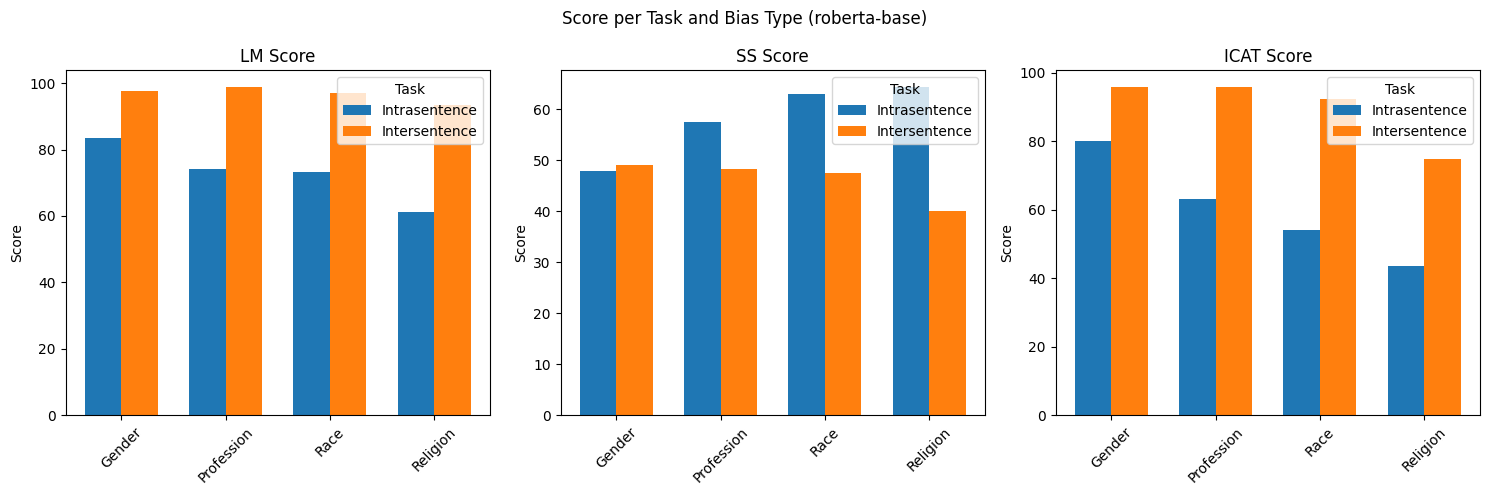

<Figure size 640x480 with 0 Axes>

In [23]:
intra = d["roberta-base"]["intrasentence"]
inter = d["roberta-base"]["intersentence"]

#visualize scores per bias target and task types
intra_data = {metric: [intra[bias][metric] for bias in bias_types] for metric in metrics}
inter_data = {metric: [inter[bias][metric] for bias in bias_types] for metric in metrics}

plot_score_records(intra_data, inter_data, nsp_model.model_name)

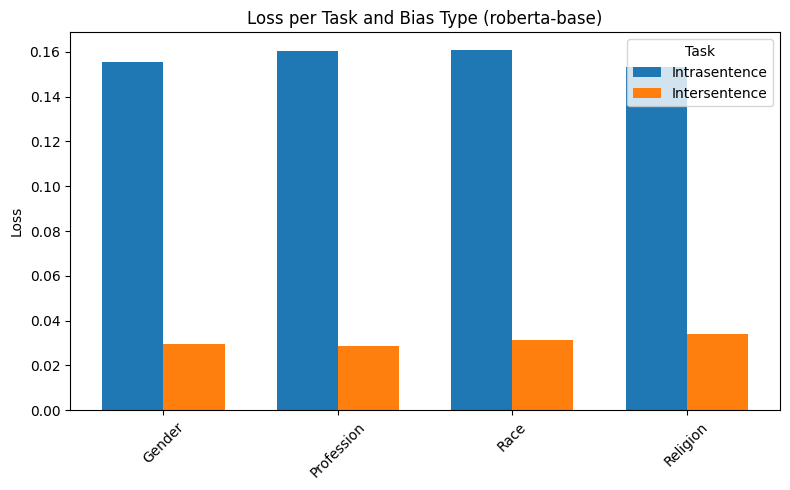

<Figure size 640x480 with 0 Axes>

In [24]:
#visualize loss per bias target and task types
intra_loss = [intra[bias]["Loss"] for bias in bias_types]
inter_loss = [inter[bias]["Loss"] for bias in bias_types]

plot_loss_scores(intra_loss, inter_loss, nsp_model.model_name)

### Bias Mitigation Strategy
The main goal is to update the model's behavior to prefer anti-stereotypical associations over stereotypical ones. In our experiment we prefer using **adapter layer** over contrastive-learning.  Instead of directly modifying the base pre-trained model (which could lead to catastrophic forgetting of its general language skills), the adapter layer acts as a new, trainable "sub-model".  
We train only the adapter layer to specifically learn the patterns present in our training dataset. So the core main model knowledge remains frozen, ensuring computational efficiency (lower number of trainable parameters w.r.t. the pre-trained ones) and model (maintaining the original knowledge of the base pre-trained model).

#### LoRA (Low Ranked Adaptation)
.....

### What about Constrative Learning?
.....

### Training Adapted Models

#### Adapted NSP Model

In [25]:
nsp_model = AdaptedNSPTransformer(model_name=pretrained_model_name, use_adapter=True)

nsp_layer_file = f"{pretrained_model_name}_{NSP_LAYER_FILE_SUFFIX}"
nsp_layer_path = os.path.join(SAVED_MODEL_DIR, nsp_layer_file)
train_adapter_layer = False

#load the NSP classification layer
nsp_model.load_nsp_layer(target_path=nsp_layer_path)

if not train_adapter_layer:
    try:
        nsp_model.load_adapter_layer(target_path=SAVED_NSP_ADAPTER_DIR)
    except:
        print("Can't load NSP adapter layer, need to trained it...")
        train_adapter_layer = True

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable parameters in the NSP adapted model:
trainable params: 887,042 || all params: 125,534,212 || trainable%: 0.7066
Loaded RobertaForSequenceClassification classification layer from saved_models/roberta-base_nsp_classification_layer.pt
Loaded RobertaForSequenceClassification adapter layer from saved_models/nsp_adapter/


c:\Users\abudo\AppData\Local\Programs\Python\Python313\Lib\site-packages\peft\tuners\tuners_utils.py:196: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


In [26]:
optimizer = AdamW(nsp_model.adapted_model.parameters(), lr=LEARNING_RATE)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=NUM_EPOCHS * len(evaluator.inter_train_dataset)) 

perfermace_records = defaultdict(list)
if train_adapter_layer:
    #Train adapter head for AutoModelForSequenceClassification
    for epoch in range(NUM_EPOCHS):
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
        train_loss = nsp_model.train_epoch(train_dataset=evaluator.inter_train_dataset,
                                           optimizer=optimizer,
                                           lr_scheduler=lr_scheduler,
                                           loss_fn=nn.MSELoss,
                                           batch_size=BATCH_SIZE, 
                                           device=evaluator.device)

        #record training and validation loss
        train_results = evaluator.evaluate_intersentence(targetModel=nsp_model, useTrainingSet=True)
        # train_loss = sum([train_result['loss'] for train_result in train_results]) / len(train_results)
        val_results = evaluator.evaluate_intersentence(targetModel=nsp_model)
        val_loss = sum([val_result['loss'] for val_result in val_results]) / len(val_results)
        print(f"Training Loss: {train_loss}, Validation Loss: {val_loss}")
        perfermace_records['train_loss'].append(train_loss)
        perfermace_records['val_loss'].append(val_loss)

        score_evaluator = ScoreEvaluator(
            gold_file_path=INPUT_FILE, predictions={"intersentence":train_results})
        train_overall = score_evaluator.get_overall_results()
        score_evaluator = ScoreEvaluator(
            gold_file_path=INPUT_FILE, predictions={"intersentence":val_results})
        val_overall = score_evaluator.get_overall_results()

        perfermace_records['train_icat'].append(train_overall['overall']['ICAT Score'])
        perfermace_records['val_icat'].append(val_overall['overall']['ICAT Score'])

Epoch 1/10


c:\Users\abudo\source\vscode_projects\MindTheGap\intersentence_loader.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(input_ids)
c:\Users\abudo\source\vscode_projects\MindTheGap\intersentence_loader.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(attention_mask)


Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


  0%|          | 0/1083 [00:00<?, ?it/s]c:\Users\abudo\source\vscode_projects\MindTheGap\SentenceEvaluator.py:246: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = self.loss_fn(torch.tensor(outputs[idx, 1].item()), torch.tensor(sentence_label[idx]))
  0%|          | 3/1083 [00:00<00:41, 25.75it/s]c:\Users\abudo\source\vscode_projects\MindTheGap\SentenceEvaluator.py:246: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = self.loss_fn(torch.tensor(outputs[idx, 1].item()), torch.tensor(sentence_label[idx]))
100%|██████████| 1083/1083 [00:44<00:00, 24.43it/s]



Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 192/192 [00:07<00:00, 24.52it/s]



Training Loss: 0.024798793879512608, Validation Loss: 0.007664486009590621
Example ID: bb7a8bd19a8cfdf1381f60715adfdbb5, Sentence ID: 20eb4fa5c9d23ac9feaf78b1cbddef10, Gold Label: anti-stereotype
Example ID: bb7a8bd19a8cfdf1381f60715adfdbb5, Sentence ID: 907a891041d6c036e71e57867753157a, Gold Label: stereotype
Example ID: bb7a8bd19a8cfdf1381f60715adfdbb5, Sentence ID: 53ed092cc068d16e24a77324b8115287, Gold Label: unrelated
Example ID: bb7a8bd19a8cfdf1381f60715adfdbb5, Sentence ID: 20eb4fa5c9d23ac9feaf78b1cbddef10, Gold Label: anti-stereotype
Example ID: bb7a8bd19a8cfdf1381f60715adfdbb5, Sentence ID: 907a891041d6c036e71e57867753157a, Gold Label: stereotype
Example ID: bb7a8bd19a8cfdf1381f60715adfdbb5, Sentence ID: 53ed092cc068d16e24a77324b8115287, Gold Label: unrelated


c:\Users\abudo\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\abudo\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch 2/10
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 1083/1083 [00:43<00:00, 24.81it/s]



Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 192/192 [00:07<00:00, 24.81it/s]



Training Loss: 0.01166953296253381, Validation Loss: 0.005049376031058237
Example ID: bb7a8bd19a8cfdf1381f60715adfdbb5, Sentence ID: 20eb4fa5c9d23ac9feaf78b1cbddef10, Gold Label: anti-stereotype
Example ID: bb7a8bd19a8cfdf1381f60715adfdbb5, Sentence ID: 907a891041d6c036e71e57867753157a, Gold Label: stereotype
Example ID: bb7a8bd19a8cfdf1381f60715adfdbb5, Sentence ID: 53ed092cc068d16e24a77324b8115287, Gold Label: unrelated
Epoch 3/10
Example ID: bb7a8bd19a8cfdf1381f60715adfdbb5, Sentence ID: 20eb4fa5c9d23ac9feaf78b1cbddef10, Gold Label: anti-stereotype
Example ID: bb7a8bd19a8cfdf1381f60715adfdbb5, Sentence ID: 907a891041d6c036e71e57867753157a, Gold Label: stereotype
Example ID: bb7a8bd19a8cfdf1381f60715adfdbb5, Sentence ID: 53ed092cc068d16e24a77324b8115287, Gold Label: unrelated
Epoch 3/10
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...
Moving model to GPU...
Underlying model moved to cuda.
Adap

100%|██████████| 1083/1083 [00:43<00:00, 24.77it/s]



Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 192/192 [00:07<00:00, 24.57it/s]



Training Loss: 0.009262828470521577, Validation Loss: 0.006605040729231425
Example ID: bb7a8bd19a8cfdf1381f60715adfdbb5, Sentence ID: 20eb4fa5c9d23ac9feaf78b1cbddef10, Gold Label: anti-stereotype
Example ID: bb7a8bd19a8cfdf1381f60715adfdbb5, Sentence ID: 907a891041d6c036e71e57867753157a, Gold Label: stereotype
Example ID: bb7a8bd19a8cfdf1381f60715adfdbb5, Sentence ID: 53ed092cc068d16e24a77324b8115287, Gold Label: unrelated
Epoch 4/10
Epoch 4/10
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 1083/1083 [00:43<00:00, 24.94it/s]


Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 192/192 [00:07<00:00, 24.93it/s]



Training Loss: 0.008650598775600184, Validation Loss: 0.005138429852751819
Example ID: bb7a8bd19a8cfdf1381f60715adfdbb5, Sentence ID: 20eb4fa5c9d23ac9feaf78b1cbddef10, Gold Label: anti-stereotype
Example ID: bb7a8bd19a8cfdf1381f60715adfdbb5, Sentence ID: 907a891041d6c036e71e57867753157a, Gold Label: stereotype
Example ID: bb7a8bd19a8cfdf1381f60715adfdbb5, Sentence ID: 53ed092cc068d16e24a77324b8115287, Gold Label: unrelated
Epoch 5/10
Epoch 5/10
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 1083/1083 [00:43<00:00, 24.62it/s]


Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 192/192 [00:07<00:00, 24.89it/s]



Training Loss: 0.006672159203224809, Validation Loss: 0.006251521128972065
Example ID: bb7a8bd19a8cfdf1381f60715adfdbb5, Sentence ID: 20eb4fa5c9d23ac9feaf78b1cbddef10, Gold Label: anti-stereotype
Example ID: bb7a8bd19a8cfdf1381f60715adfdbb5, Sentence ID: 907a891041d6c036e71e57867753157a, Gold Label: stereotype
Example ID: bb7a8bd19a8cfdf1381f60715adfdbb5, Sentence ID: 53ed092cc068d16e24a77324b8115287, Gold Label: unrelated
Epoch 6/10
Epoch 6/10
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 1083/1083 [00:43<00:00, 24.78it/s]



Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 192/192 [00:07<00:00, 24.93it/s]



Training Loss: 0.00715081801349458, Validation Loss: 0.004334863324205803
Example ID: bb7a8bd19a8cfdf1381f60715adfdbb5, Sentence ID: 20eb4fa5c9d23ac9feaf78b1cbddef10, Gold Label: anti-stereotype
Example ID: bb7a8bd19a8cfdf1381f60715adfdbb5, Sentence ID: 907a891041d6c036e71e57867753157a, Gold Label: stereotype
Example ID: bb7a8bd19a8cfdf1381f60715adfdbb5, Sentence ID: 53ed092cc068d16e24a77324b8115287, Gold Label: unrelated
Epoch 7/10
Example ID: bb7a8bd19a8cfdf1381f60715adfdbb5, Sentence ID: 20eb4fa5c9d23ac9feaf78b1cbddef10, Gold Label: anti-stereotype
Example ID: bb7a8bd19a8cfdf1381f60715adfdbb5, Sentence ID: 907a891041d6c036e71e57867753157a, Gold Label: stereotype
Example ID: bb7a8bd19a8cfdf1381f60715adfdbb5, Sentence ID: 53ed092cc068d16e24a77324b8115287, Gold Label: unrelated
Epoch 7/10
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...
Moving model to GPU...
Underlying model moved to cuda.
Adap

100%|██████████| 1083/1083 [00:45<00:00, 23.95it/s]


Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 192/192 [00:07<00:00, 24.17it/s]



Training Loss: 0.005579802812341565, Validation Loss: 0.004972435156639955
Example ID: bb7a8bd19a8cfdf1381f60715adfdbb5, Sentence ID: 20eb4fa5c9d23ac9feaf78b1cbddef10, Gold Label: anti-stereotype
Example ID: bb7a8bd19a8cfdf1381f60715adfdbb5, Sentence ID: 907a891041d6c036e71e57867753157a, Gold Label: stereotype
Example ID: bb7a8bd19a8cfdf1381f60715adfdbb5, Sentence ID: 53ed092cc068d16e24a77324b8115287, Gold Label: unrelated
Epoch 8/10
Example ID: bb7a8bd19a8cfdf1381f60715adfdbb5, Sentence ID: 20eb4fa5c9d23ac9feaf78b1cbddef10, Gold Label: anti-stereotype
Example ID: bb7a8bd19a8cfdf1381f60715adfdbb5, Sentence ID: 907a891041d6c036e71e57867753157a, Gold Label: stereotype
Example ID: bb7a8bd19a8cfdf1381f60715adfdbb5, Sentence ID: 53ed092cc068d16e24a77324b8115287, Gold Label: unrelated
Epoch 8/10
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...
Moving model to GPU...
Underlying model moved to cuda.
Ada

100%|██████████| 1083/1083 [00:43<00:00, 24.81it/s]


Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 192/192 [00:07<00:00, 24.86it/s]



Training Loss: 0.00529506922739554, Validation Loss: 0.004782657083796461
Example ID: bb7a8bd19a8cfdf1381f60715adfdbb5, Sentence ID: 20eb4fa5c9d23ac9feaf78b1cbddef10, Gold Label: anti-stereotype
Example ID: bb7a8bd19a8cfdf1381f60715adfdbb5, Sentence ID: 907a891041d6c036e71e57867753157a, Gold Label: stereotype
Example ID: bb7a8bd19a8cfdf1381f60715adfdbb5, Sentence ID: 53ed092cc068d16e24a77324b8115287, Gold Label: unrelated
Epoch 9/10
Epoch 9/10
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 1083/1083 [00:43<00:00, 24.83it/s]



Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 192/192 [00:07<00:00, 24.87it/s]



Training Loss: 0.005102738547681678, Validation Loss: 0.00400514881528792
Example ID: bb7a8bd19a8cfdf1381f60715adfdbb5, Sentence ID: 20eb4fa5c9d23ac9feaf78b1cbddef10, Gold Label: anti-stereotype
Example ID: bb7a8bd19a8cfdf1381f60715adfdbb5, Sentence ID: 907a891041d6c036e71e57867753157a, Gold Label: stereotype
Example ID: bb7a8bd19a8cfdf1381f60715adfdbb5, Sentence ID: 53ed092cc068d16e24a77324b8115287, Gold Label: unrelated
Epoch 10/10
Epoch 10/10
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 1083/1083 [00:43<00:00, 24.63it/s]


Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 192/192 [00:07<00:00, 24.58it/s]



Training Loss: 0.004659742316304227, Validation Loss: 0.003961216691160555
Example ID: bb7a8bd19a8cfdf1381f60715adfdbb5, Sentence ID: 20eb4fa5c9d23ac9feaf78b1cbddef10, Gold Label: anti-stereotype
Example ID: bb7a8bd19a8cfdf1381f60715adfdbb5, Sentence ID: 907a891041d6c036e71e57867753157a, Gold Label: stereotype
Example ID: bb7a8bd19a8cfdf1381f60715adfdbb5, Sentence ID: 53ed092cc068d16e24a77324b8115287, Gold Label: unrelated


In [27]:
#save adapter layer's weights
if train_adapter_layer:
    nsp_model.save_adapter_layer(target_path=SAVED_NSP_ADAPTER_DIR)

Saved RobertaForSequenceClassification adapter layer in saved_models/nsp_adapter/


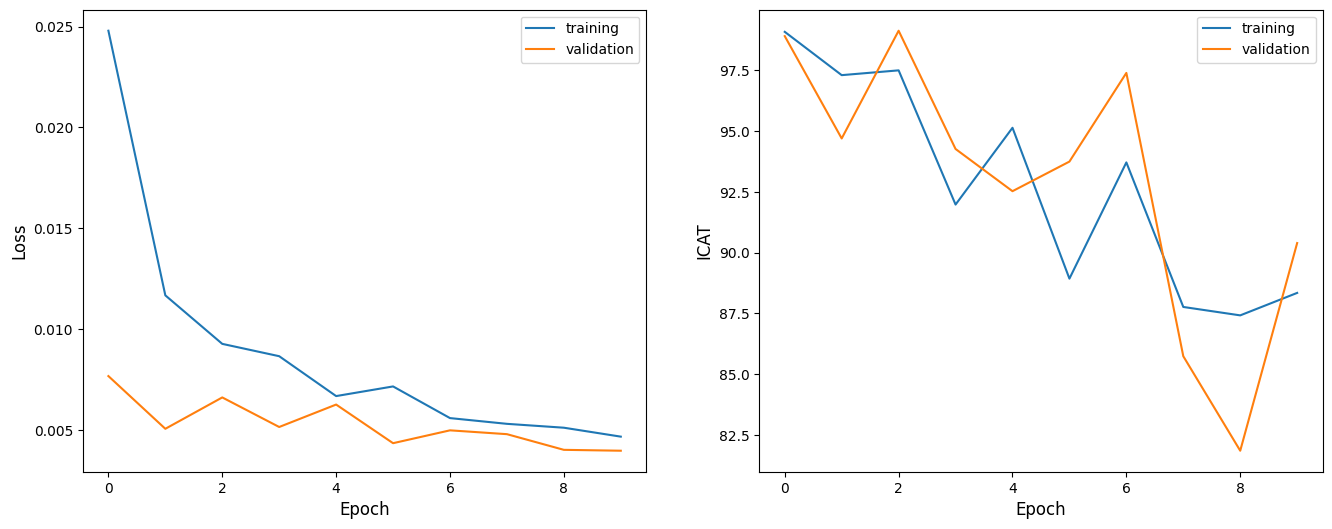

In [28]:
if train_adapter_layer: #the NSP adapter layer has been trained
    performance_plot(perfermace_records, ignore_icat_plot=False)

#### Adapted MLM Model

In [6]:
mlm_model = AdaptedMLMTransformer(model_name=pretrained_model_name, use_adapter=True)
train_adapter_layer = False

if not train_adapter_layer:
    try:
        mlm_model.load_adapter_layer(target_path=SAVED_MLM_ADAPTER_DIR)
    except:
        print("Can't load MLM adapter layer, need to trained it...")
        train_adapter_layer = True

Trainable parameters in the MLM adapted model:
trainable params: 294,912 || all params: 124,992,345 || trainable%: 0.2359
Can't load MLM adapter layer, need to trained it...


In [7]:
optimizer = AdamW(mlm_model.adapted_model.parameters(), lr=LEARNING_RATE)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=NUM_EPOCHS * len(evaluator.intra_train_dataset)) 

perfermace_records = defaultdict(list)
if train_adapter_layer:
    #Train adapter head for AutoModelForMaskedLM
    for epoch in range(NUM_EPOCHS):
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
        train_loss = mlm_model.train_epoch(train_dataset=evaluator.intra_train_dataset,
                                           optimizer=optimizer,
                                           lr_scheduler=lr_scheduler,
                                           loss_fn=nn.MSELoss,
                                           batch_size=BATCH_SIZE, 
                                           device=evaluator.device)

        #record training and validation loss
        train_results = evaluator.evaluate_intrasentence(targetModel=mlm_model, useTrainingSet=True)
        #train_loss = sum([train_result['loss'] for train_result in train_results]) / len(train_results)
        val_results = evaluator.evaluate_intrasentence(targetModel=mlm_model)
        val_loss = sum([val_result['loss'] for val_result in val_results]) / len(val_results)
        print(f"Training Loss: {train_loss}, Validation Loss: {val_loss}")
        perfermace_records['train_loss'].append(train_loss)
        perfermace_records['val_loss'].append(val_loss)
        
        score_evaluator = ScoreEvaluator(
            gold_file_path=INPUT_FILE, predictions={"intrasentence":train_results})
        train_overall = score_evaluator.get_overall_results()
        score_evaluator = ScoreEvaluator(
            gold_file_path=INPUT_FILE, predictions={"intrasentence":val_results})
        val_overall = score_evaluator.get_overall_results()

        perfermace_records['train_icat'].append(train_overall['overall']['ICAT Score'])
        perfermace_records['val_icat'].append(val_overall['overall']['ICAT Score'])

Epoch 1/10
Moving model to GPU...
Underlying model moved to cuda.
AdaptedMLMTransformer instance moved to GPU.
Let's use 1 GPUs!
Calculating intrasentence predictions...
Moving model to GPU...
Underlying model moved to cuda.
AdaptedMLMTransformer instance moved to GPU.
Let's use 1 GPUs!
Calculating intrasentence predictions...


100%|██████████| 1866/1866 [02:51<00:00, 10.90it/s]



Moving model to GPU...
Underlying model moved to cuda.
AdaptedMLMTransformer instance moved to GPU.
Let's use 1 GPUs!
Calculating intrasentence predictions...


100%|██████████| 338/338 [00:31<00:00, 10.88it/s]



Training Loss: 0.15223585972751563, Validation Loss: 0.14051001690557324


c:\Users\abudo\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\abudo\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch 2/10
Moving model to GPU...
Underlying model moved to cuda.
AdaptedMLMTransformer instance moved to GPU.
Let's use 1 GPUs!
Calculating intrasentence predictions...
Moving model to GPU...
Underlying model moved to cuda.
AdaptedMLMTransformer instance moved to GPU.
Let's use 1 GPUs!
Calculating intrasentence predictions...


100%|██████████| 1866/1866 [02:53<00:00, 10.75it/s]



Moving model to GPU...
Underlying model moved to cuda.
AdaptedMLMTransformer instance moved to GPU.
Let's use 1 GPUs!
Calculating intrasentence predictions...


100%|██████████| 338/338 [00:31<00:00, 10.78it/s]



Training Loss: 0.141844620858974, Validation Loss: 0.13498651103284895
Epoch 3/10
Epoch 3/10
Moving model to GPU...
Underlying model moved to cuda.
AdaptedMLMTransformer instance moved to GPU.
Let's use 1 GPUs!
Calculating intrasentence predictions...
Moving model to GPU...
Underlying model moved to cuda.
AdaptedMLMTransformer instance moved to GPU.
Let's use 1 GPUs!
Calculating intrasentence predictions...


100%|██████████| 1866/1866 [02:53<00:00, 10.74it/s]



Moving model to GPU...
Underlying model moved to cuda.
AdaptedMLMTransformer instance moved to GPU.
Let's use 1 GPUs!
Calculating intrasentence predictions...


100%|██████████| 338/338 [00:31<00:00, 10.72it/s]



Training Loss: 0.13540890739598488, Validation Loss: 0.1325605164629164
Epoch 4/10
Epoch 4/10
Moving model to GPU...
Underlying model moved to cuda.
AdaptedMLMTransformer instance moved to GPU.
Let's use 1 GPUs!
Calculating intrasentence predictions...
Moving model to GPU...
Underlying model moved to cuda.
AdaptedMLMTransformer instance moved to GPU.
Let's use 1 GPUs!
Calculating intrasentence predictions...


100%|██████████| 1866/1866 [02:55<00:00, 10.66it/s]



Moving model to GPU...
Underlying model moved to cuda.
AdaptedMLMTransformer instance moved to GPU.
Let's use 1 GPUs!
Calculating intrasentence predictions...


100%|██████████| 338/338 [00:31<00:00, 10.65it/s]



Training Loss: 0.13271185050850928, Validation Loss: 0.12935570461440943
Epoch 5/10
Epoch 5/10
Moving model to GPU...
Underlying model moved to cuda.
AdaptedMLMTransformer instance moved to GPU.
Let's use 1 GPUs!
Calculating intrasentence predictions...
Moving model to GPU...
Underlying model moved to cuda.
AdaptedMLMTransformer instance moved to GPU.
Let's use 1 GPUs!
Calculating intrasentence predictions...


100%|██████████| 1866/1866 [02:54<00:00, 10.66it/s]



Moving model to GPU...
Underlying model moved to cuda.
AdaptedMLMTransformer instance moved to GPU.
Let's use 1 GPUs!
Calculating intrasentence predictions...


100%|██████████| 338/338 [00:31<00:00, 10.69it/s]



Training Loss: 0.1305972702478172, Validation Loss: 0.12941827767937336
Epoch 6/10
Epoch 6/10
Moving model to GPU...
Underlying model moved to cuda.
AdaptedMLMTransformer instance moved to GPU.
Let's use 1 GPUs!
Calculating intrasentence predictions...
Moving model to GPU...
Underlying model moved to cuda.
AdaptedMLMTransformer instance moved to GPU.
Let's use 1 GPUs!
Calculating intrasentence predictions...


100%|██████████| 1866/1866 [02:55<00:00, 10.66it/s]



Moving model to GPU...
Underlying model moved to cuda.
AdaptedMLMTransformer instance moved to GPU.
Let's use 1 GPUs!
Calculating intrasentence predictions...


100%|██████████| 338/338 [00:31<00:00, 10.68it/s]



Training Loss: 0.13008169780759227, Validation Loss: 0.12676927210303485
Epoch 7/10
Epoch 7/10
Moving model to GPU...
Underlying model moved to cuda.
AdaptedMLMTransformer instance moved to GPU.
Let's use 1 GPUs!
Calculating intrasentence predictions...
Moving model to GPU...
Underlying model moved to cuda.
AdaptedMLMTransformer instance moved to GPU.
Let's use 1 GPUs!
Calculating intrasentence predictions...


100%|██████████| 1866/1866 [02:39<00:00, 11.70it/s]



Moving model to GPU...
Underlying model moved to cuda.
AdaptedMLMTransformer instance moved to GPU.
Let's use 1 GPUs!
Calculating intrasentence predictions...


100%|██████████| 338/338 [00:18<00:00, 18.35it/s]



Training Loss: 0.12906436553191386, Validation Loss: 0.12612129487160456
Epoch 8/10
Epoch 8/10
Moving model to GPU...
Underlying model moved to cuda.
AdaptedMLMTransformer instance moved to GPU.
Let's use 1 GPUs!
Calculating intrasentence predictions...
Moving model to GPU...
Underlying model moved to cuda.
AdaptedMLMTransformer instance moved to GPU.
Let's use 1 GPUs!
Calculating intrasentence predictions...


100%|██████████| 1866/1866 [01:42<00:00, 18.18it/s]



Moving model to GPU...
Underlying model moved to cuda.
AdaptedMLMTransformer instance moved to GPU.
Let's use 1 GPUs!
Calculating intrasentence predictions...


100%|██████████| 338/338 [00:18<00:00, 18.23it/s]



Training Loss: 0.1281892112717886, Validation Loss: 0.12511287527172993
Epoch 9/10
Epoch 9/10
Moving model to GPU...
Underlying model moved to cuda.
AdaptedMLMTransformer instance moved to GPU.
Let's use 1 GPUs!
Calculating intrasentence predictions...
Moving model to GPU...
Underlying model moved to cuda.
AdaptedMLMTransformer instance moved to GPU.
Let's use 1 GPUs!
Calculating intrasentence predictions...


100%|██████████| 1866/1866 [01:42<00:00, 18.21it/s]



Moving model to GPU...
Underlying model moved to cuda.
AdaptedMLMTransformer instance moved to GPU.
Let's use 1 GPUs!
Calculating intrasentence predictions...


100%|██████████| 338/338 [00:18<00:00, 18.23it/s]



Training Loss: 0.12700315027490036, Validation Loss: 0.12535175789131892
Epoch 10/10
Epoch 10/10
Moving model to GPU...
Underlying model moved to cuda.
AdaptedMLMTransformer instance moved to GPU.
Let's use 1 GPUs!
Calculating intrasentence predictions...
Moving model to GPU...
Underlying model moved to cuda.
AdaptedMLMTransformer instance moved to GPU.
Let's use 1 GPUs!
Calculating intrasentence predictions...


100%|██████████| 1866/1866 [01:42<00:00, 18.19it/s]



Moving model to GPU...
Underlying model moved to cuda.
AdaptedMLMTransformer instance moved to GPU.
Let's use 1 GPUs!
Calculating intrasentence predictions...


100%|██████████| 338/338 [00:18<00:00, 18.22it/s]



Training Loss: 0.12629062113294062, Validation Loss: 0.12548002392900162


In [8]:
#save adapter layer's weights
if train_adapter_layer:
    mlm_model.save_adapter_layer(target_path=SAVED_MLM_ADAPTER_DIR)

Saved RobertaForMaskedLM adapter layer in saved_models/mlm_adapter/


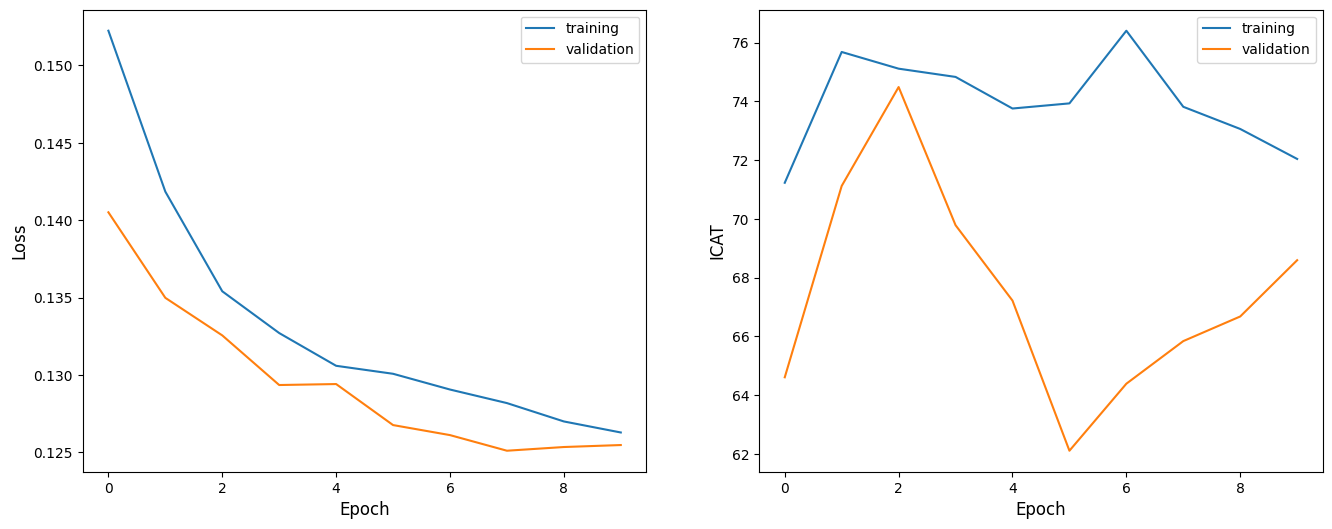

In [12]:
if train_adapter_layer: #the MLM adapter layer has been trained
    performance_plot(perfermace_records, ignore_icat_plot=False)

### Calculate Test Set Predictions (after applying bias mitigation)
Either for intersentences or intrasentences

In [26]:
results = evaluator.evaluate(intra_targetModel=mlm_model, inter_targetModel=nsp_model)
#print(results)

#save evaluation predictions
output_file = f"{nsp_model.model_name}_{OUTPUT_FILE_PRETRAINED}"
output_file = os.path.join(OUTPUT_DIR, output_file)
with open(output_file, "w+") as f:
    json.dump(results, f, indent=2)

Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


  0%|          | 0/192 [00:00<?, ?it/s]c:\Users\abudo\source\vscode_projects\MindTheGap\intersentence_loader.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(input_ids)
c:\Users\abudo\source\vscode_projects\MindTheGap\intersentence_loader.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(attention_mask)
c:\Users\abudo\source\vscode_projects\MindTheGap\SentenceEvaluator.py:246: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = self.loss_fn(torch.tensor(outputs[idx, 1].item())

Moving model to GPU...
Underlying model moved to cuda.
AdaptedMLMTransformer instance moved to GPU.
Let's use 1 GPUs!
Calculating intrasentence predictions...


100%|██████████| 338/338 [00:18<00:00, 18.59it/s]



### Bias Evaluation of Adapted Pre-trained Model

In [27]:
print(f'Overall scores for ({mlm_model.model_name}):')
score_evaluator = ScoreEvaluator(
    gold_file_path=INPUT_FILE, predictions=results)
overall = score_evaluator.get_overall_results()
score_evaluator.pretty_print(overall['overall'])

#load existing results of any model
if os.path.exists(RESULTS_FILE):
    with open(RESULTS_FILE, "r") as f:
        print("Loading already existing results file...")
        d = json.load(f)
else:
    d = {}

#assuming that the file follows a format of {MODELNAME}_predictions.json"
predictions_filename = os.path.basename(output_file)
if "_predictions" in predictions_filename:
    pretrained_class = predictions_filename.replace("_predictions.json", "")
    d[pretrained_class] = overall
else:
    d = overall

print(f"Saving results to {RESULTS_FILE}...")
with open(RESULTS_FILE, "w+") as f:
    json.dump(d, f, indent=2)

Overall scores for (adapted_roberta-base):
Count: 635.0
LM Score: 95.39657193054929
SS Score: 57.524357166262554
ICAT Score: 81.0406143376991
Loss: 0.0635709995528079
Loading already existing results file...
Saving results to results.json...


### Model Plots (after applying bias mitigation)

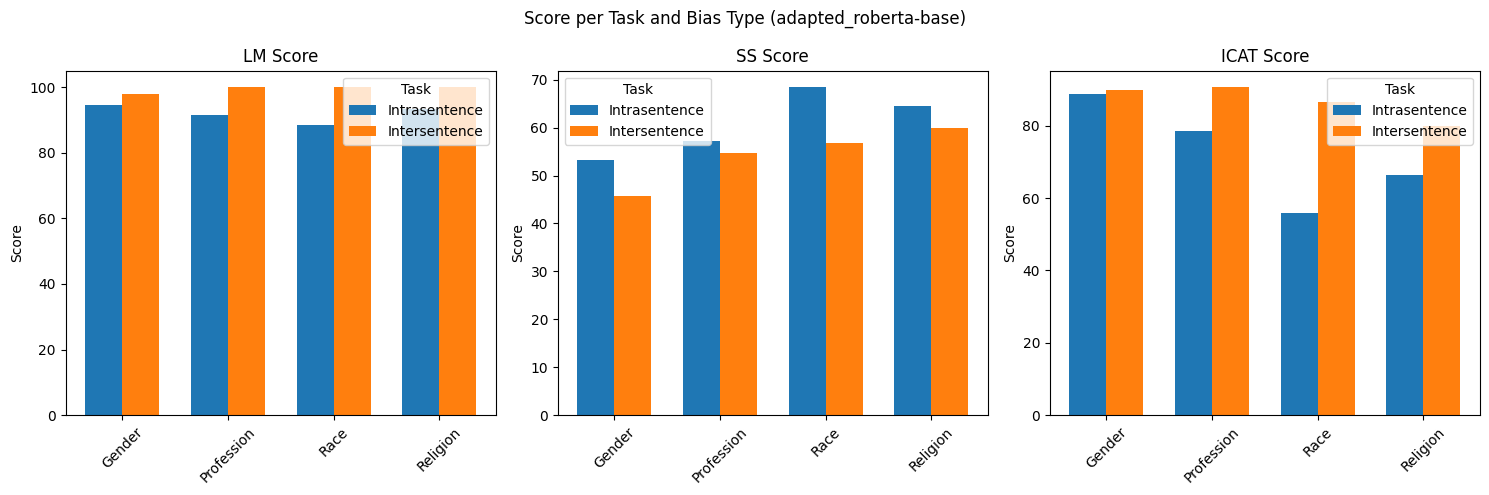

<Figure size 640x480 with 0 Axes>

In [29]:
intra = d[mlm_model.model_name]["intrasentence"]
inter = d[mlm_model.model_name]["intersentence"]

#visualize scores per bias target and task types
intra_data = {metric: [intra[bias][metric] for bias in bias_types] for metric in metrics}
inter_data = {metric: [inter[bias][metric] for bias in bias_types] for metric in metrics}

plot_score_records(intra_data, inter_data, mlm_model.model_name)

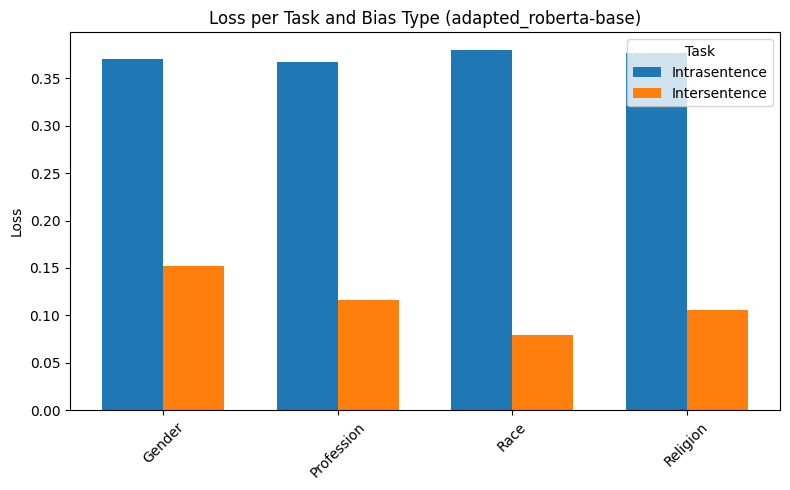

<Figure size 640x480 with 0 Axes>

In [28]:
#visualize loss per bias target and task types
intra_loss = [intra[bias]["Loss"] for bias in bias_types]
inter_loss = [inter[bias]["Loss"] for bias in bias_types]

plot_loss_scores(intra_loss, inter_loss, mlm_model.model_name)

### Overall Comparison between Perfomances (before and after adaptation)

Loading already existing results file...


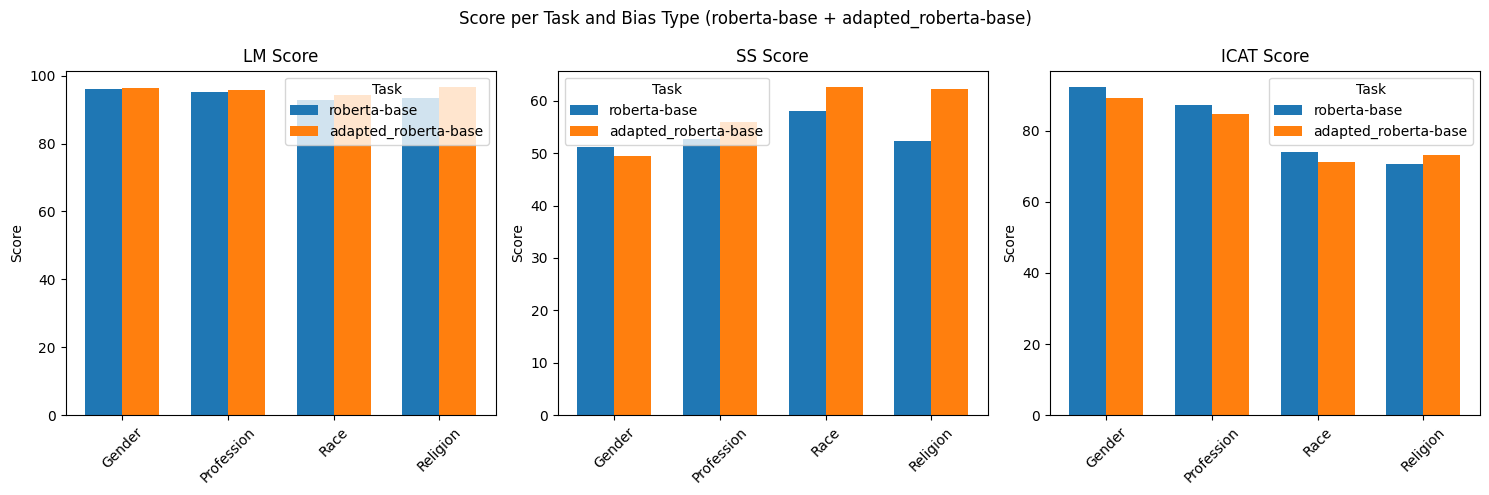

<Figure size 640x480 with 0 Axes>

In [20]:
#load existing results of any model
if os.path.exists(RESULTS_FILE):
    with open(RESULTS_FILE, "r") as f:
        print("Loading already existing results file...")
        d = json.load(f)
else:
    d = {}

adapted_model_name = f"adapted_{pretrained_model_name}"
base_model_overall = {bias: {metric : (d[pretrained_model_name]["intrasentence"][bias][metric] + d[pretrained_model_name]["intersentence"][bias][metric])/2 for metric in metrics} for bias in bias_types}
adapted_model_overall = {bias: {metric : (d[adapted_model_name]["intrasentence"][bias][metric] + d[adapted_model_name]["intersentence"][bias][metric])/2 for metric in metrics} for bias in bias_types}

#visualize scores per bias target and task types
base_model_data = {metric: [base_model_overall[bias][metric] for bias in bias_types] for metric in metrics}
adapted_model_data = {metric: [adapted_model_overall[bias][metric] for bias in bias_types] for metric in metrics}

plot_score_records(base_model_data, adapted_model_data, f"{pretrained_model_name} + {adapted_model_name}", pretrained_model_name, adapted_model_name)

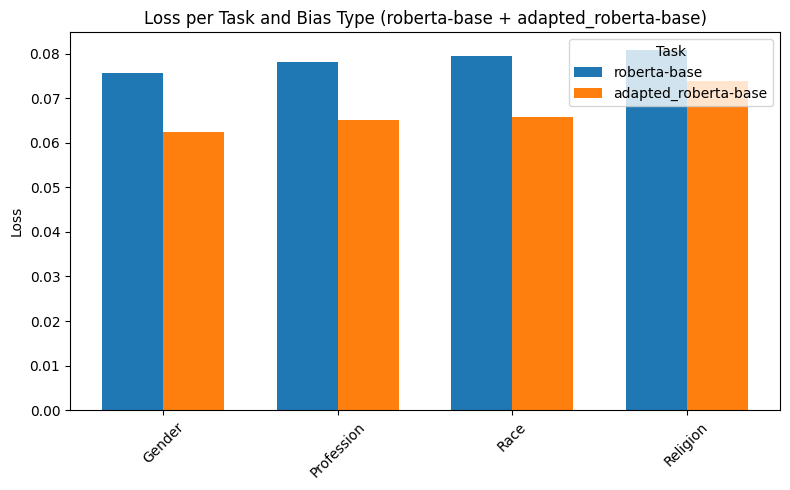

<Figure size 640x480 with 0 Axes>

In [27]:
#visualize loss per bias target and task types
base_model_loss = [(d[pretrained_model_name]["intrasentence"][bias]["Loss"] + d[pretrained_model_name]["intersentence"][bias]["Loss"])/2 for bias in bias_types]
adapted_model_loss = [(d[adapted_model_name]["intrasentence"][bias]["Loss"] + d[adapted_model_name]["intersentence"][bias]["Loss"])/2 for bias in bias_types]

plot_loss_scores(base_model_loss, adapted_model_loss, f"{pretrained_model_name} + {adapted_model_name}", pretrained_model_name, adapted_model_name)